<a href="https://colab.research.google.com/github/bartwronski/BlogPostsExtraMaterial/blob/master/Bilateral_and_guided_SSAO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from IPython.display import Image
import scipy.ndimage
import scipy.misc
import PIL.Image as Image2
import IPython.display
import urllib.request

In [0]:
urllib.request.urlretrieve('https://www.dropbox.com/s/lf7rbr0bhzn3qp8/ssao_and_depth.tiff?dl=1', filename="ssao_and_depth.tiff")
urllib.request.urlretrieve('https://www.dropbox.com/s/r6uo3nsemh96j3b/depth_large.tiff?dl=1', filename="depth_large.tiff")

('depth_large.tiff', <http.client.HTTPMessage at 0x7fa1b65912b0>)

In [0]:
input_image = (cv2.imread("ssao_and_depth.tiff", -1) / 65535.0)[:,:,(0,1,2)]
input_image_fullres = (cv2.imread("depth_large.tiff", -1) / 65535.0)[:,:,(0,1,2)]

signal = input_image[:,:,2]
guide = input_image[:,:,1]
fullres = input_image_fullres[:,:,2]

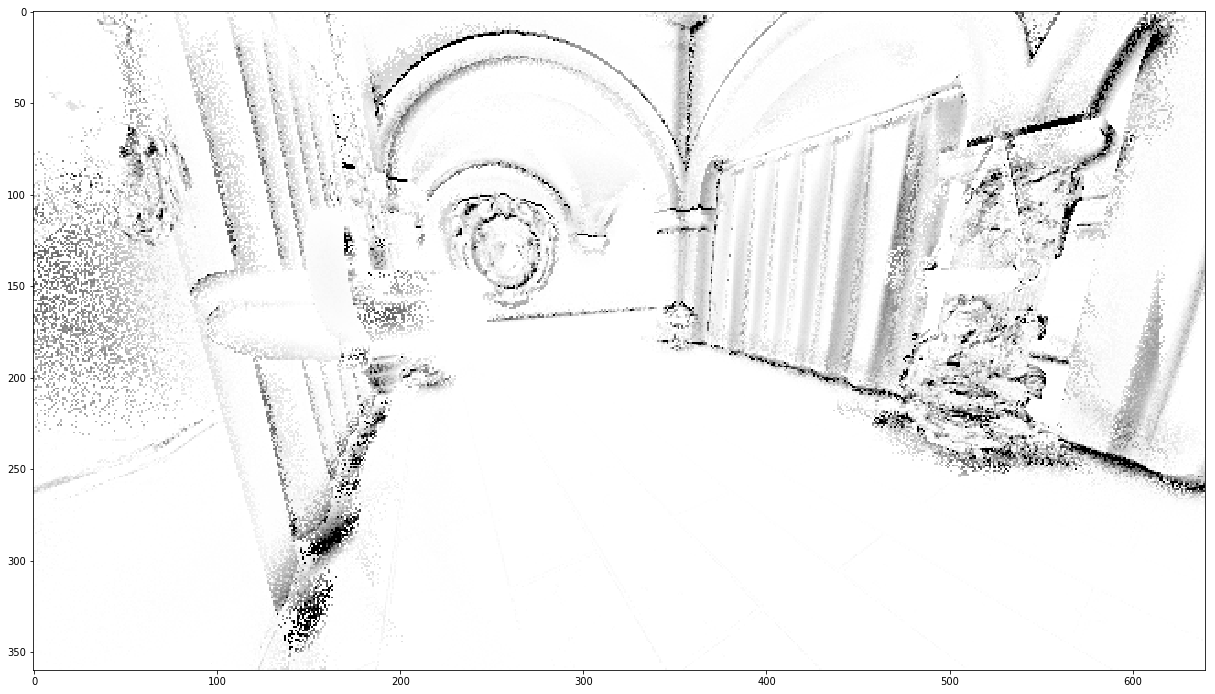

In [0]:
plt.rcParams['figure.figsize'] = [21, 20]
def display_img(img):
  plt.imshow(np.clip(img,0,1)[:,:,np.newaxis][:,:,(0,0,0)],vmin=0,vmax=1)
display_img(signal)

In [0]:
def filter_bilateral(signal_in, guide_in, sigma_s, sigma_v, window):
  gaussian = lambda r2, sigma: np.exp( -0.5*r2/sigma**2 )
  # initialize to epsilon
  wgt_sum = np.ones( signal_in.shape ) * 1e-8
  result  = signal_in * 1e-8

  for shft_x in range(-window, window+1):
    for shft_y in range(-window, window+1):
      # spatial weight
      w = gaussian(shft_x**2 + shft_y**2, sigma_s)

      # shift the image
      off_signal = np.roll(signal_in, [shft_y, shft_x], axis=[0,1])
      off_guide = np.roll(guide_in, [shft_y, shft_x], axis=[0,1])

      # compute the final weight as a product of spatial and signal weights
      tw = w * gaussian((guide_in-off_guide)**2, sigma_v)

      # accumulate the results
      result += off_signal * tw
      wgt_sum += tw

  # dehomogenize the result
  return result / wgt_sum

In [0]:
def bilinear_interp_x(a):
  a_fullres = np.zeros((a.shape[0]*2,a.shape[1]))
  a_fullres[0::2,:] = a * 0.75 + np.roll(a, 1, axis=0) * 0.25
  a_fullres[1::2,:] = a * 0.75 + np.roll(a, -1, axis=0) * 0.25
  return a_fullres
def bilinear_interp_y(a):
  a_fullres = np.zeros((a.shape[0],a.shape[1] * 2))
  a_fullres[:,0::2] = a * 0.75 + np.roll(a, 1, axis=1) * 0.25
  a_fullres[:,1::2] = a * 0.75 + np.roll(a, -1, axis=1) * 0.25
  return a_fullres
def bilinear_interp(a):
  a_fullres = np.zeros((a.shape[0] * 2,a.shape[1] * 2))
  for phase_x in range(0, 2):
    for phase_y in range(0, 2):
      roll_x = 1 if phase_x == 0 else -1
      roll_y = 1 if phase_y == 0 else -1
      w0 = 0.75 * 0.75
      w1 = 0.75 * 0.25
      w2 = 0.25 * 0.75
      w3 = 0.25 * 0.25
      a_fullres[phase_x::2,phase_y::2] = a * w0 + np.roll(a, roll_x, axis=0) * w1 + np.roll(a, roll_y, axis=1) * w2 + np.roll(np.roll(a, roll_y, axis=1),roll_x, axis=0) * w3
  return a_fullres
def joint_bilateral_interp(a, b, b_fullres, sigma):
  a_fullres = np.zeros((a.shape[0] * 2,a.shape[1] * 2))
  for phase_x in range(0, 2):
    for phase_y in range(0, 2):
      roll_x = 1 if phase_x == 0 else -1
      roll_y = 1 if phase_y == 0 else -1
      eps = 0.000001
      w0 = 0.75 * 0.75 * np.exp(-np.power(b_fullres[phase_x::2,phase_y::2] - b, 2) * sigma) + eps
      w1 = 0.75 * 0.25 * np.exp(-np.power(b_fullres[phase_x::2,phase_y::2] - np.roll(b, roll_x, axis=0), 2) * sigma) + eps
      w2 = 0.25 * 0.75 * np.exp(-np.power(b_fullres[phase_x::2,phase_y::2] - np.roll(b, roll_y, axis=1), 2) * sigma) + eps
      w3 = 0.25 * 0.25 * np.exp(-np.power(b_fullres[phase_x::2,phase_y::2] - np.roll(np.roll(b, roll_y, axis=1), roll_x, axis=0), 2) * sigma) + eps
      w0_norm = w0 / (w0 + w1 + w2 + w3)
      w1_norm = w1 / (w0 + w1 + w2 + w3)
      w2_norm = w2 / (w0 + w1 + w2 + w3)
      w3_norm = w3 / (w0 + w1 + w2 + w3)
      a_fullres[phase_x::2,phase_y::2] = a * w0_norm + np.roll(a, roll_x, axis=0) * w1_norm + np.roll(a, roll_y, axis=1) * w2_norm + np.roll(np.roll(a, roll_y, axis=1),roll_x, axis=0) * w3_norm
  return a_fullres


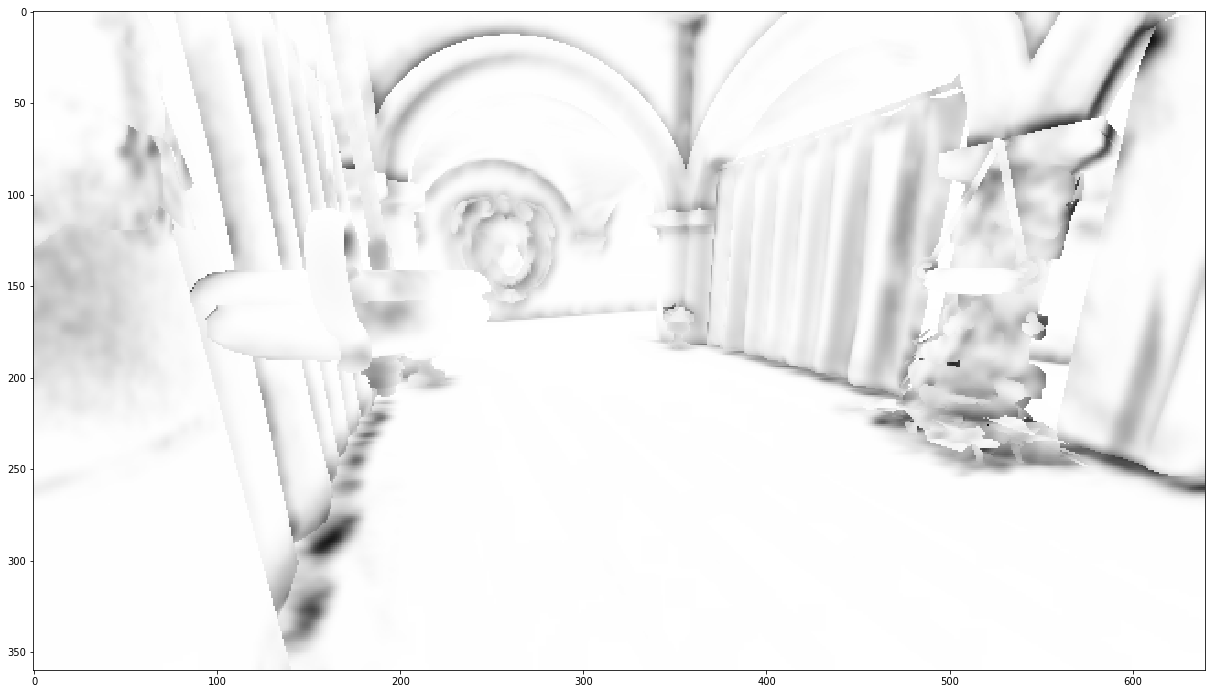

In [0]:
display_img(filter_bilateral(signal, guide, 3, 0.001, 7))

In [0]:
def filter_guided(signal_in, guide_in, fullres_in, sigma_s, window, reg_constant=0.000001, second_order=False):
  gaussian = lambda r2, sigma: np.exp( -0.5*r2/sigma**2 )
  x = np.zeros(signal_in.shape)
  x2 = np.zeros(signal_in.shape)
  x3 = np.zeros(signal_in.shape)
  x4 = np.zeros(signal_in.shape)
  y = np.zeros(signal_in.shape)
  xy = np.zeros(signal_in.shape)
  x2y = np.zeros(signal_in.shape)
  w = 0.0
    
  for shft_x in range(-window, window+1):
    for shft_y in range(-window, window+1):
      # shift by the offsets
      off_signal = np.roll(signal_in, [shft_y, shft_x], axis=[0,1])
      off_guide = np.roll(guide_in, [shft_y, shft_x], axis=[0,1])

      ww = gaussian(shft_x**2 + shft_y**2, sigma_s)

      # accumulate the results
      x += off_guide * ww
      x2 += off_guide * off_guide * ww
      x3 += off_guide * off_guide * off_guide * ww
      x4 += off_guide * off_guide * off_guide * off_guide * ww
      y += off_signal * ww
      xy += off_guide * off_signal * ww
      x2y += off_guide * off_guide * off_signal * ww
      w += ww
  x /= w
  x2 /= w
  x3 /= w
  x4 /= w
  y /= w
  xy /= w
  x2y /= w
  cyx = (xy - x * y)
  cyx2 = (x2y - x2 * y)
  cxx2 = (x3 - x2 * x)
  vx1 = x2 - x*x
  vx2 = x4 - x2 * x2
  if second_order:
    beta1 = (cyx * vx2 - cyx2 * cxx2)  / (vx1 * vx2 - cxx2 * cxx2)
    beta2 = (cyx2 * vx1 - cyx * cxx2)  / (vx1 * vx2 - cxx2 * cxx2)
    alpha = y - beta1 * x - beta2 * x2
  else:
    beta1 = cyx / (vx1 + reg_constant)
    beta2 = np.zeros(signal_in.shape)
    alpha = y - beta1 * x
  if fullres_in is not None:
    return bilinear_interp(beta1) * fullres_in + bilinear_interp(beta2) * fullres_in * fullres_in + bilinear_interp(alpha)

  # normalize the result and return
  return beta1 * guide_in + beta2 * guide_in * guide_in + alpha

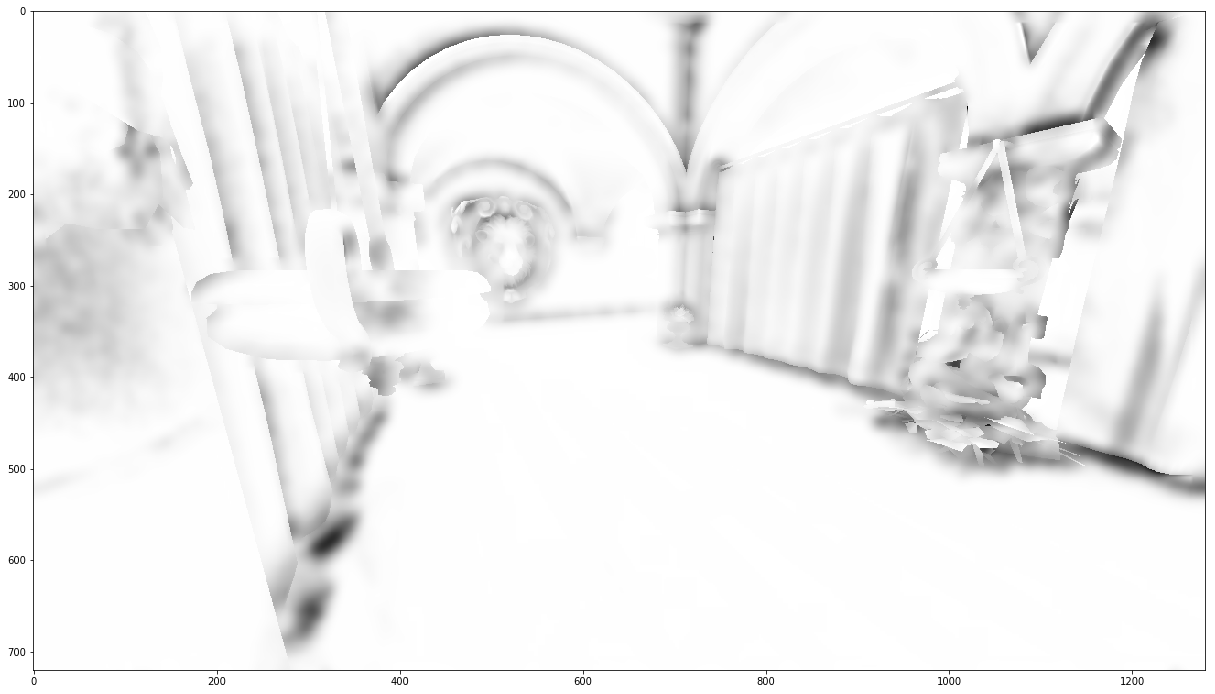

In [0]:
display_img(filter_guided(signal, guide, fullres, 3, 7, reg_constant = 0.00000001))

In [0]:
def filter_gaussian(signal_in, sigma_s, window):
  gaussian = lambda r2, sigma: np.exp(-0.5*r2/sigma**2)
  wgt_sum = np.zeros(signal_in.shape)
  result  = np.zeros(signal_in.shape)

  for shft_x in range(-window, window + 1):
    for shft_y in range(-window, window + 1):
      # spatial weight
      w = gaussian( shft_x**2 + shft_y**2, sigma_s )

      # shift the image
      off_signal = np.roll(signal_in, [shft_y, shft_x], axis=[0,1])

      # accumulate the results
      result += off_signal * w
      wgt_sum += w

  # normalize the result and return
  return result/wgt_sum

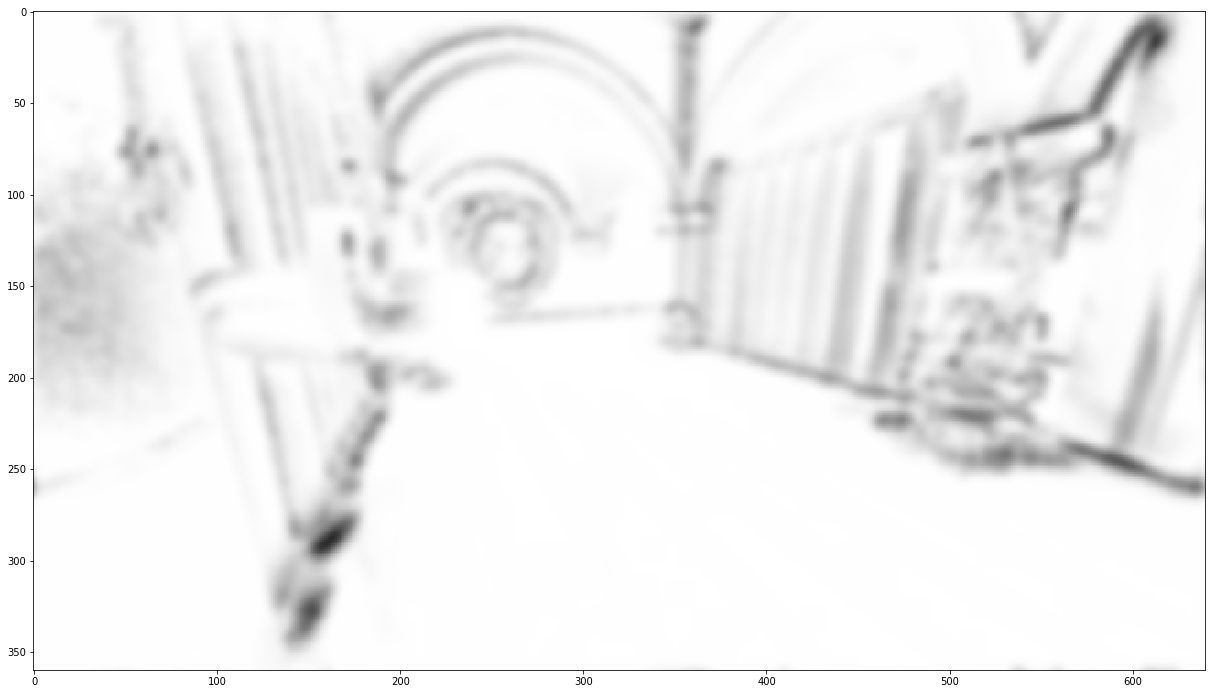

In [0]:
display_img(filter_gaussian(signal, 3, 7))

In [0]:
def filter_bilateral_separable(signal_in, guide_in, sigma_s, sigma_v, window):
  gaussian = lambda r2, sigma: np.exp(-0.5*r2/sigma**2)
  wgt_sum = np.ones(signal_in.shape) * 1e-8
  result = signal_in * 1e-8

  for shft_x in range(-window, window + 1):
    shft_y = 0
    # spatial weight
    w = gaussian(shft_x**2 + shft_y**2, sigma_s)

    # shift the image
    off_signal = np.roll(signal_in, [shft_y, shft_x], axis=[0,1])
    off_guide = np.roll(guide_in, [shft_y, shft_x], axis=[0,1])

    # compute the final  weight
    tw = w * gaussian((guide_in-off_guide)**2, sigma_v)

    # accumulate the results
    result += off_signal*tw
    wgt_sum += tw
  
  filtered_signal = result/wgt_sum
  wgt_sum = np.ones(filtered_signal.shape) * 1e-8
  result = filtered_signal * 1e-8

  for shft_y in range(-window, window + 1):
    shft_x = 0
    # spatial weight
    w = gaussian(shft_x**2 + shft_y**2, sigma_s)

    # shift the image
    off_signal = np.roll(filtered_signal, [shft_y, shft_x], axis=[0,1])
    off_guide = np.roll(guide_in, [shft_y, shft_x], axis=[0,1])

    # compute the final  weight
    tw = w*gaussian((guide_in-off_guide)**2, sigma_v)

    # accumulate the results
    result += off_signal*tw
    wgt_sum += tw

  # normalize the result and return
  return result/wgt_sum

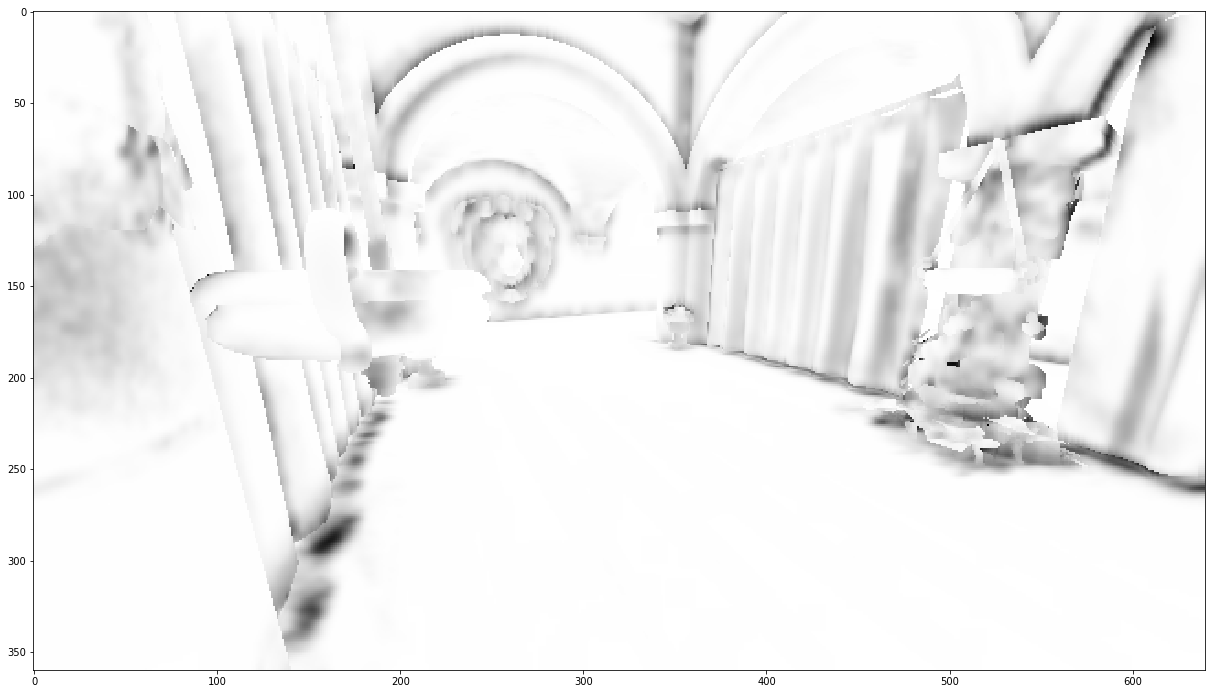

In [0]:
display_img(filter_bilateral_separable(signal, guide, 3, 0.001, 7))

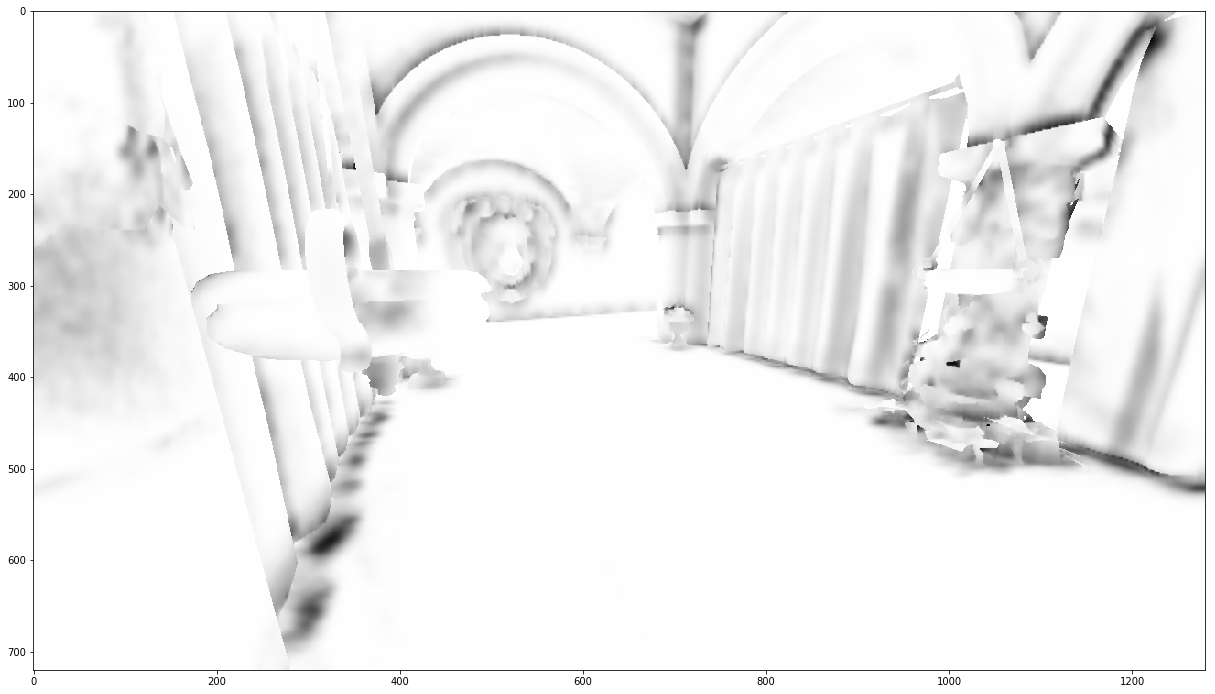

In [0]:
display_img(joint_bilateral_interp(filter_bilateral_separable(signal, guide, 3, 0.001, 7), guide, fullres, 100000.0))

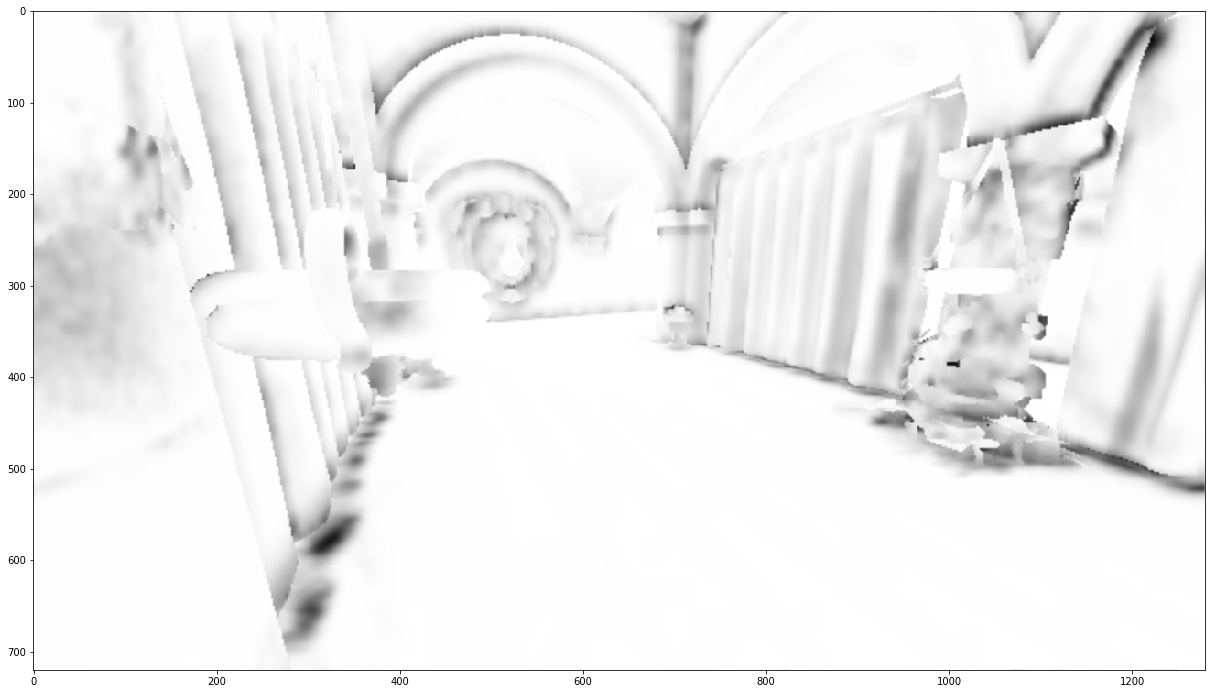

In [0]:
display_img(bilinear_interp(filter_bilateral_separable(signal, guide, 3, 0.001, 7)))

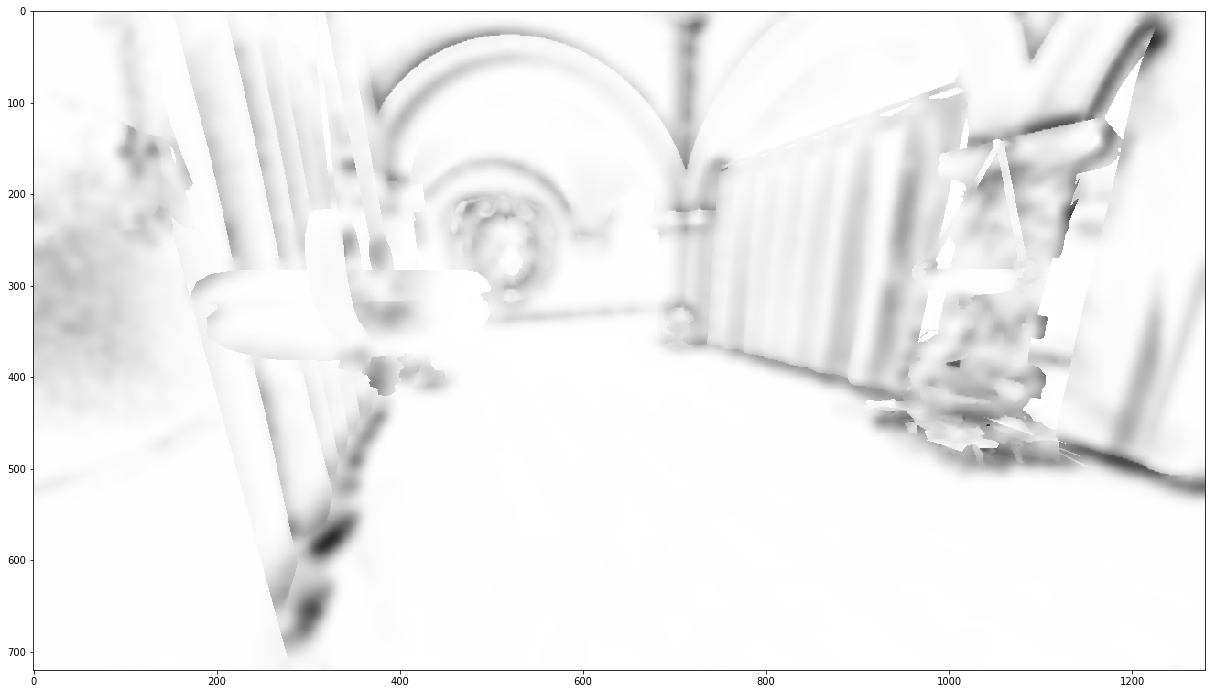

In [0]:
display_img(joint_bilateral_interp(filter_guided(signal, guide, None, 3, 7), guide, fullres, 100000.0))

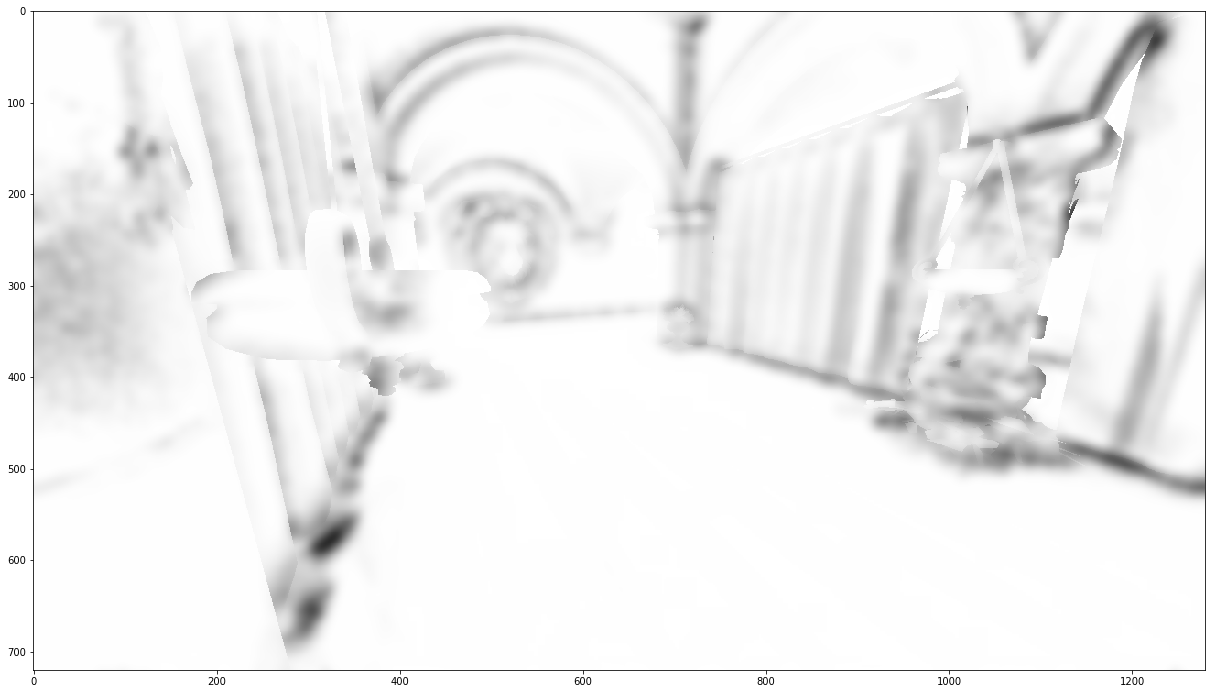

In [0]:
display_img(filter_guided(signal, guide, fullres, 3, 7, reg_constant = 0.00002))